### Standard imports and global variables

In [1]:
import ast
import json
import importlib
from pathlib import Path
from functools import reduce
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

spec = importlib.util.spec_from_file_location("utils", "../../src/processing/utils.py")
utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils)

In [2]:
FIGURES_DIR = "../../figures/"

### Converting raw data to appropriate formats

In [3]:
path_to_article_data = "../../data/raw/user_study_results/dataclips_aolcedkqrfjfehnxrhunrbysyepr.json"
article_evals = utils.read_json(path_to_article_data)
print(article_evals.keys())

article_evals_df = pd.DataFrame(article_evals["values"], columns=article_evals["fields"])
display(article_evals_df.head())

dict_keys(['title', 'values', 'fields', 'types', 'type_names', 'started_at', 'finished_at', 'checksum'])


,id,doc_id,rating,optional_reasons
0,1,43,rating-3,"['optional-reason-1', 'optional-reason-2', 'op..."
1,2,29,rating-5,[]
2,3,oos_4,rating-5,[]
3,4,oos_8,rating-4,['optional-reason-2']
4,5,11,rating-4,['optional-reason-5']


#### Converting  raw database rating values to Likert scale

In [4]:
def rating_index(rating_value):
    return int(rating_value[-1])

likert_scale = ["Very\nPoor", "Poor", "Acceptable", "Good", "Very\nGood"]
rating_values = sorted(article_evals_df.rating.unique(), key=rating_index)
article_evals_df.rating = (article_evals_df
                                .rating
                                .map(dict(zip(rating_values, likert_scale)))
                                .astype("category"))
article_evals_df

,id,doc_id,rating,optional_reasons
0,1,43,Acceptable,"['optional-reason-1', 'optional-reason-2', 'op..."
1,2,29,Very\nGood,[]
2,3,oos_4,Very\nGood,[]
3,4,oos_8,Good,['optional-reason-2']
4,5,11,Good,['optional-reason-5']
...,...,...,...,...
456,489,43,Very\nGood,[]
457,490,44,Very\nGood,[]
458,491,46,Good,[]
459,492,50,Very\nGood,[]


#### Converting raw database optional reason values to values defined in the Web app

In [5]:
article_evals_df.optional_reasons = article_evals_df.optional_reasons.apply(ast.literal_eval)

with pd.option_context("display.max_colwidth",  100):
    display(article_evals_df)

,id,doc_id,rating,optional_reasons
0,1,43,Acceptable,"[optional-reason-1, optional-reason-2, optional-reason-3]"
1,2,29,Very\nGood,[]
2,3,oos_4,Very\nGood,[]
3,4,oos_8,Good,[optional-reason-2]
4,5,11,Good,[optional-reason-5]
...,...,...,...,...
456,489,43,Very\nGood,[]
457,490,44,Very\nGood,[]
458,491,46,Good,[]
459,492,50,Very\nGood,[]


In [7]:
# To check if all optional reasons where used
def optional_reason_factory(mask=None):
    if mask is not None:
        df = article_evals_df[mask]
    else:
        df = article_evals_df
    return reduce(list.__add__, 
                  [list_ for _, list_ in df.optional_reasons.iteritems() 
                   if len(list_) > 0])
    
all_optional_reasons = optional_reason_factory()

set(all_optional_reasons)

{'optional-reason-1',
 'optional-reason-2',
 'optional-reason-3',
 'optional-reason-4',
 'optional-reason-5',
 'optional-reason-6'}

In [17]:
positive_optional_reason_labels = (
    ["Topic company is present\nin model results",
     "Model results contain companies\nthat are in a similar economic sector", 
     "Model results contain companies\nthat are in a similar economic industry", 
     "Model results contain companies\nthat are related to the topic company", 
     "Personal knowledge on the topic company\nand/or on the topic of the article",
     "Other reasons (not specified)"]
)

negative_optional_reason_labels = (
    ["Topic company is not present in model results",
     "Model results contain companies that are not is similar economic sector", 
     "Model results contain companies that are not is similar economic industry", 
     "Model results contain companies that are not related to the topic company", 
     "Personal knowledge on the topic company and/or on the topic of the article",
     "Other reasons (not specified)"]
)

### Setting up common plotting params

In [9]:
rc = utils.plotting.rc
palette = utils.plotting.discrete_palette
sns.set(style="whitegrid", rc=rc)

### Case example: NIO

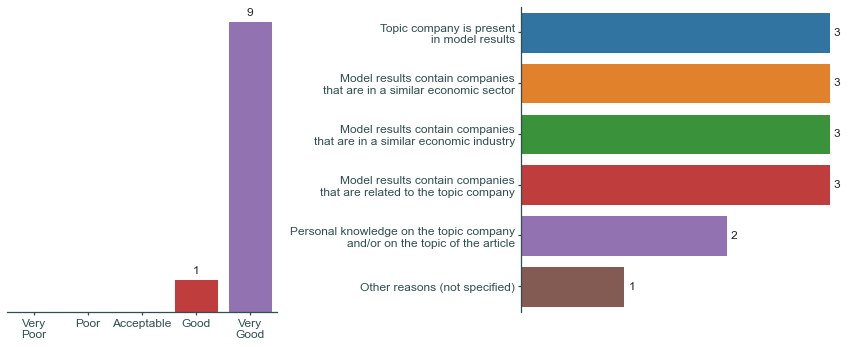

In [33]:
nio_doc_id = "3"
nio_mask = article_evals_df.doc_id == nio_doc_id
nio_optional_reasons = optional_reason_factory(nio_mask)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.2]})

sns.countplot(x="rating", data=article_evals_df[nio_mask], 
                order=likert_scale, palette=palette, ax=ax1)
ax1.bar_label(ax1.containers[0], padding=4)
ax1.spines["left"].set_visible(False)
ax1.tick_params(axis="y", left=False)
ax1.set_yticklabels([])
ax1.set_ylabel(None)
ax1.set_xlabel(None)

sns.countplot(y=nio_optional_reasons, palette=palette, ax=ax2)
ax2.set_yticklabels(positive_optional_reason_labels)
ax2.bar_label(ax2.containers[0], padding=4)
ax2.spines["bottom"].set_visible(False)
ax2.tick_params(axis="x", bottom=False)
ax2.set_xticklabels([])
ax2.set_ylabel(None)
ax2.set_xlabel(None)


fig.tight_layout()
plt.show()

fig.savefig(Path(FIGURES_DIR) / "nio_evaluations.png", dpi=200)